Mild: 0.0005 + 0.004 * dfc["ballpark_mysticism"] (ALL SEASONS)

Haunted: 0.2 (Season 12) More to come, likely a logging error

Electric: 0.05 + 0.1 * dfc["ballpark_mysticism"] (SEASON 12-15)
          0.0325 + 0.1 * dfc["ballpark_mysticism"] or 0.033 + 0.1 * dfc["ballpark_mysticism"] (SEASON 16)
          0.025 + 0.1*dfc["ballpark_mysticism"] (SEASON 17)
          0.02085 + 0.1*dfc["ballpark_mysticism"] (SEASON 18)

Peanut Mister: 0.0005 (ALL SEASONS. NOTE: IF NO ELIGIBLE TARGETS THEN NO TARGET ROLL)

Smithy: 0.0004 (ALL SEASONS)

Taste the Infinite (Pitcher): 0.001 (ALL SEASONS)

Birds Ambush: 0.0255 (ALL SEASONS)

Charm: 0.015 + 0.02*dfc["ballpark_mysticism"] (SEASON 12-17)  
       0.014 + 0.006*dfc["ballpark_mysticism"] (SEASON 18)

Echo Chamber: 0.0055 (SEASON 14-17)
              0.013 (SEASON 18)
              Between 0.006 & 0.012 (SEASON 19)

Base Intincts: 0.2 (ALL SEASONS)


Debt_Three: 0.0095 (ALL SEASONS FOR ACTUAL REAL DEBT)
            0.015 (ALL SEASONS BUT FOR COPIED DEBT)
            (THIS IS LIKELY CAUSED BY A STAT BUT IT'S HARD TO TELL WITH LIMITED DATA AND CHORBY SHELLING SOUL WITH FLOORED STATS)

Psychic (Pitcher): 0.075ish
Psychic (Batter): 0.078 + 0.0375*dfc["ballpark_mysticism"]

In [ ]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

pd.set_option("display.max_rows", 60)  # default 60
pd.set_option("display.max_columns", 20)  # default 20

In [ ]:
all_files = glob.glob("../roll_data/*-modproc.csv")

df = pd.concat((pd.read_csv(f, dtype=column_dtypes) for f in all_files), ignore_index=True)

seasons = [14,15,16,17,18]
df = df[df['season'].isin(seasons)]
len(df)

In [ ]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass  # traveling just doesn't do anything on pitchers?
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass  # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    return mul


def get_batter_mul(row):
    # if row[["runner_name"]].isna().any():
    # row["runner_name"] == "NaaN"
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    attrs = ""
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # is this actually 0.035 instead of 0.05?
            mul += 0.35
    if "GROWTH" in btm:
        # is this actually 0.035 instead of 0.05?
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "power" attrs
        mul += 1.0
        attrs = "batter_musclitude, batter_divinity, batter_ground_friction"
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "speed" attrs
        # doing 80% because of evidence from the Spin Attack blessing that "speed"
        # boosts laserlikeness 80% of what it says the total boost is?
        mul += 0.80
        attrs = "batter_musclitude, batter_laserlikeness, batter_ground_friction, batter_continuation"
    if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
        mul += 1.25
        # pass
    # NVGs real??? eclipse weather, special case for Sutton Dreamy
    # surely this will not break from scattering, right? (It totally will)
    # if row["runner_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
    # NVGs allow the player to play 50% better in a solar eclipse.
    # This might affect fielding and baserunning as well?
    # mul += 0.50
    return mul, attrs


def get_fielder_mul(row):
    fm = str(row["fielder_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == 18 and str(row["baserunner_count"]) > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    # if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
    # NVGs allow the player to play 50% better in a solar eclipse.
    # This might affect fielding and baserunning as well?
    # mul += 0.50
    return mul

In [ ]:
dfc = df.copy()
for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]

len(dfc)

In [ ]:
mister_events = ("cure", "NoCure")
mild_events = ("Mild", "NoMild")
birds_ambush_events = ("Ambushed", "NoBush")
echo_chamber_events = ("Copy", "nocopy")
taste_infinite_events = ("shelled2", "no shell2")
electric_events = ("Zap", "NoZap")
base_instinct_events = ("Walk", "Balk", "Second", "Third")
smithy_events = ("Fix", "NoFix")
haunted_events = ("NoHaunt", "YesHaunt")
grind_rail_events = ("Grind", "NoGrind")
taste_infinite_batter_events = ("shelled1", "no shell1")
debt_events = ("Bonk", "No Bonk")
big_buckets_events = ("Bucket", "NoBucket")
acidic_events = ("Acidic Pitch", "Not Acidic Pitch")
double_strike_events = ("Double Strike", "Single Strike")
hotel_motel_events = ("Hotel", "Notel")

include_events = double_strike_events

dfc = dfc[dfc["event_type"].astype(str).isin(include_events)]

if "Hotel" in include_events:
    # These rolls are not in the right place currently
    dfc = dfc[~dfc["inning"] == -1]

len(dfc)

In [802]:
X = dfc[
    [
        "roll",
        "passed",
        #"pitcher_musclitude",
        #"ballpark_mysticism",
        #"ballpark_forwardness"
        #"pitcher_unthwackability"

    ]
].copy()
#X = X[X["pitcher_musclitude"] > 0.07]

y = X["passed"]
X = X.drop(["passed"], axis=1)

pin_intercept = None
pins = [ #(0.02, "ballpark_mysticism")
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(
    dual=False, max_iter=10000000, C=100000000, tol=1e-12, fit_intercept=pin_intercept is None
).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0, 1] + confusion_matrix(y, predictionsvm)[1, 0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[[24185   225]
 [  216   748]]
441 outliers
0.9826200047292504
0.03572411737246579


[(1.0, 'roll')]

In [797]:
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))

2701
99


In [789]:

dfc["threshold"] = 0.009 + 0.011274885732420673*dfc["pitcher_ruthlessness"]

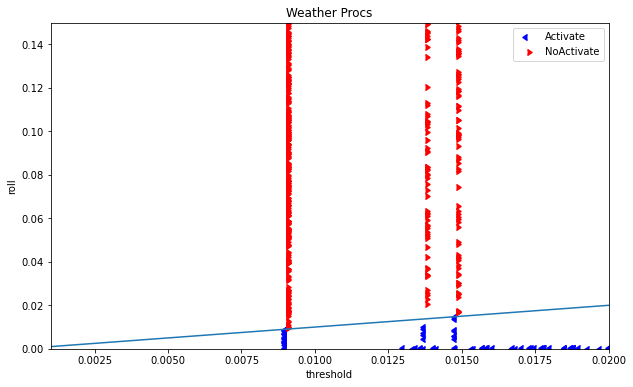

In [790]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Activate", marker=CARETLEFTBASE)
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="NoActivate", marker=CARETRIGHTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Weather Procs")
ax.set_xlim([0.001, 0.02])
ax.set_ylim([0.0, 0.15])
ax.legend()

,offset,event_type,season,roll,threshold,ballpark_forwardness,batter_name,pitcher_name,batter_mods,pitcher_mods,day,game_id,play_count


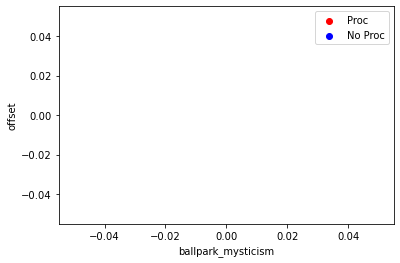

In [792]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
#outliers = outliers[outliers["pitcher_musclitude"] > 0.07]
fig, ax = plt.subplots(1)
x_val = "ballpark_mysticism"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Proc")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="No Proc")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "event_type", "season",
       "roll", "threshold", "ballpark_forwardness",
       "batter_name", "pitcher_name", "batter_mods", "pitcher_mods",
       "day",  "game_id", "play_count"]].sort_values('offset')


In [662]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.014591677356671662
0.00959761035961626
